# CSE 572: Lab 17

In this lab, you will practice implementing anomaly detection (also known as outlier detection) techniques for a real-world dataset. Anomaly detection is the task of identifying instances whose characteristics differ significantly from the rest of the data. You should refer to the lecture slides and Chapter 9 of the "Introduction to Data Mining" book to understand some of the concepts in this tutorial. 

Acknowledgment: This notebook was adapted from Introduction to Data Mining, 2nd Edition. Tan, Steinbach, Karpatne, Kumar.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Model-based statistical approaches

This approach assumes that the majority of the data instances are governed by some well-known probability distribution, e.g., Binomial or Gaussian distribution. Anomalies can then be detected as observations that do not fit the overall distribution of the data. 

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data *stocks.csv* contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). 

In [3]:
import pandas as pd

stocks = pd.read_csv('https://docs.google.com/uc?export=download&id=1UqHZmlfSoPDcZlTIr2TB6OadBhni9Kbv', header='infer')
stocks

stocks.index = stocks['Date']
stocks = stocks.drop(['Date'], axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [4]:
import numpy as np

N, d = stocks.shape

delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                     columns=stocks.columns, 
                     index=stocks.iloc[1:].index)

delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


Plot the daily change in price as a line for each of the companies.

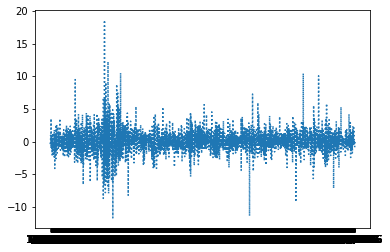

In [5]:
# MSFT - YOUR CODE HERE
import matplotlib.pyplot as plt

plt.plot(delta['MSFT'], linestyle = 'dotted')

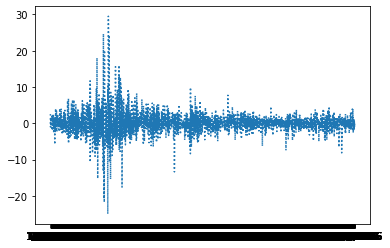

In [6]:
# F - YOUR CODE HERE
plt.plot(delta['F'], linestyle = 'dotted')

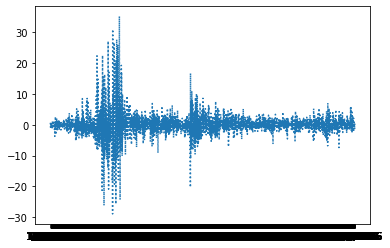

In [7]:
# BAC - YOUR CODE HERE
plt.plot(delta['BAC'], linestyle = 'dotted')

We can also plot the *distribution* of the percentage daily changes in stock price for all three features (treated as attributes) as a 3D scatter plot.

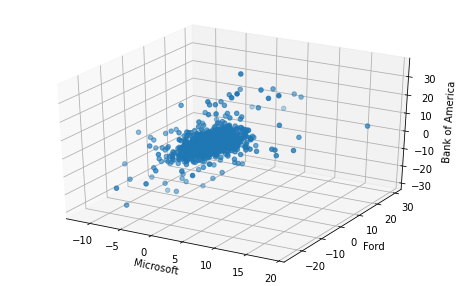

In [8]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(delta.MSFT, delta.F, delta.BAC)
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
plt.show()

Assuming the data follow a multivariate Gaussian distribution, we can compute the mean and covariance matrix of the 3-dimensional data. Compute and print these in the cell below. Name your variables `mean` and `cov`.

In [9]:
# YOUR CODE HERE
mean = delta.mean()
cov = delta.cov()

To determine the anomalous trading days, we can compute the Mahalanobis distance between the percentage of price change on each day against the mean percentage of price change.

\begin{equation}
\textrm{Mahalanobis}(x) = (x - \mu_x) \Sigma^{-1}(x - \mu_x)^T
\end{equation}

where $x$ is assumed to be a row vector, $\mu_x$ is the feature-wise mean of $x$, and $\Sigma^{-1}$ is the inverted covariance matrix of $x$.

In [10]:
from numpy.linalg import inv

# Invert the covariance matrix
cov_inv = np.linalg.inv(cov.to_numpy())

# Function to compute the Mahalanobis distance for one sample
def mahalanobis(row):
    sub = row - mean
    return np.matmul(sub, cov_inv).dot(sub)   

# Compute the Mahalanobis distance for every sample
anomaly_scores = np.apply_along_axis(mahalanobis, axis=1, arr=delta)

# Result is one score for each sample
anomaly_scores.shape

(2517,)

Plot the dataset as a 3d scatter plot again, but this time color the points by their anomaly score. Use `cmap=jet` for the colormap.

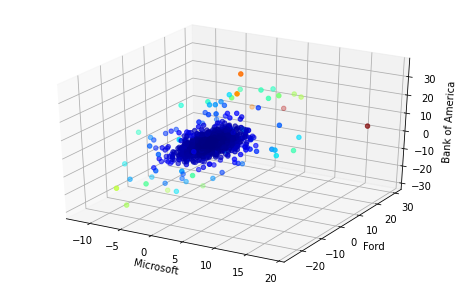

In [11]:
# YOUR CODE HERE
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(delta.MSFT, delta.F, delta.BAC, c=anomaly_scores, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
plt.show()

The top anomalies are shown as brownish-orange points in the figure above. To see which samples the top anomalies correspond to, create a new dataframe named `result` that appends the anomaly scores as a new column to `delta`. 

In [12]:
# YOUR CODE HERE
anomaly_score = pd.DataFrame(anomaly_scores, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta, anomaly_score), axis=1)
result

,MSFT,F,BAC,Anomaly score
Date,,,,
1/4/2007,-0.167455,2.529960,0.637532,0.988039
1/5/2007,-0.570278,-1.038961,-0.801185,0.185428
1/8/2007,0.978411,1.443570,0.394438,0.416341
1/9/2007,0.100231,0.776197,0.093543,0.074004
1/10/2007,-1.001332,-0.770218,0.149536,0.464471
...,...,...,...,...
12/23/2016,-0.487800,0.483871,0.266189,0.187138
12/27/2016,0.063246,-0.561798,0.044252,0.064622
12/28/2016,-0.458276,-1.129944,-1.238394,0.203058


Now we can print the N samples (here, 10 samples) with the largest anomaly scores using the `nlargest()` function.

In [13]:
result.nlargest(10, 'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,126.992257
11/26/2008,2.501251,29.518072,4.256757,121.360808
4/9/2009,2.501297,7.341772,35.269122,100.466343
11/28/2008,-1.317721,25.116279,5.314323,98.117362
1/21/2009,4.870124,-1.877934,30.980392,95.630501
11/19/2008,-6.778797,-25.000000,-14.022383,73.876496
9/30/2008,6.717317,24.700240,15.702479,71.393091
1/20/2009,-6.240482,-2.739726,-28.969359,71.165307
12/8/2008,5.737287,24.264706,17.060367,69.706051


See the Wikipedia article for the global financial crisis for context on what happened during these dates: https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008

**Question 1: We can see that the top anomaly corresponds to the sample from October 13, 2008, which represents the change between October 12-13, 2008. According to the Wikipedia article, what happened on this date?**

**Answer:**

The G7 nations made a commitment to "help systemically significant financial institutions and avoid their demise" on Sunday, October 12, during their weekend summit in Washington. On October 13, stock markets around the world increased, with the Dow Jones industrial average starting trading with a 400-point gain. At the end of trading, the average had increased by 936 points, a record increase of 11%, closing at 9,387.

The plot below visualizes what happened to the stock prices during the first couple weeks of October 2008.

Text(0, 0.5, 'Percent Change')

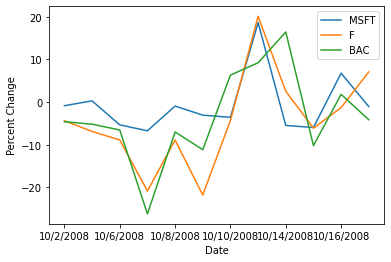

In [14]:
fig, ax = plt.subplots(1)

delta[440:452].plot(ax=ax)
ax.set_ylabel('Percent Change')

The second largest anomaly corresponds to the sample from November 26, 2008. We plot the time series around that date below.

Text(0, 0.5, 'Percent Change')

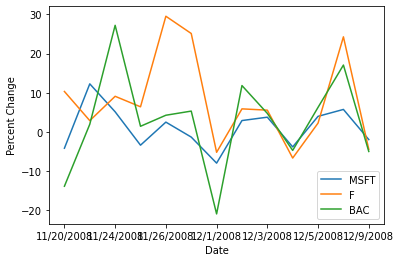

In [15]:
fig, ax = plt.subplots(1)

delta[475:488].plot(ax=ax)
ax.set_ylabel('Percent Change')

## Distance-based (model free) approaches

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate anomaly score. 

Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor. 

In the example below, we apply the distance-based approach with k=4 to identify the anomalous trading days from the stock market data described in the previous section.

In [16]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

k = 4
nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(delta.to_numpy())
distances, indices = nbrs.kneighbors(delta.to_numpy())

anomaly_score = distances[:, k-1]

Plot the dataset as a 3d scatter plot again with points colored by their anomaly score computed using the distance to k-nearest neighbors approach. Use `cmap=jet` for the colormap.

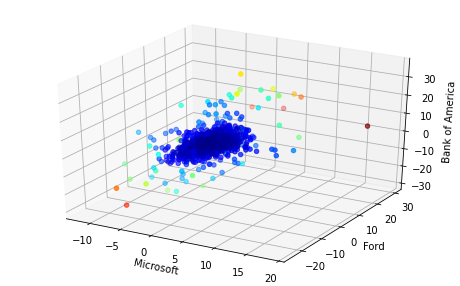

In [17]:
# YOUR CODE HERE
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(delta.MSFT, delta.F, delta.BAC, c=anomaly_score, cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
plt.show()

The results are slightly different than the results from the previous section because we have used Euclidean distance (instead of Mahalanobis distance) to detect the anomalies.

We can examine the dates associated with the top-10 highest anomaly scores as follows. 

In [18]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta, anom), axis=1)
result.nlargest(10, 'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,15.642827
11/26/2008,2.501251,29.518072,4.256757,14.212749
10/7/2008,-6.744279,-20.867209,-26.225949,13.751302
11/28/2008,-1.317721,25.116279,5.314323,13.139586
9/30/2008,6.717317,24.700240,15.702479,12.599739
11/19/2008,-6.778797,-25.000000,-14.022383,12.375693
12/8/2008,5.737287,24.264706,17.060367,11.220257
4/9/2009,2.501297,7.341772,35.269122,10.440667
7/16/2008,4.244742,18.064516,22.408207,9.752602
